![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# King County Housing Price Analysis by Copper Consulting
- Alex Dohn
- Alex Marshall
- Scott Schumann

## Overview

We have been tasked with analyzing housing market data for King County, WA to determine which features correlate most strongly with sale price. Our group is working for a local real estate company to provide them with more detailed information to give to their clients so that they can more accurately determine what price they should ask for their home. Given that there is a wide variety of house types in the market, we have been tasked specifically with analyzing information pertaining to single family homes in the area.

## Business Problem

Our task is analyzing housing data features that correlate most strongly with sale price. This is valuable information for our stakeholder given that they will be able to provide more accurate information to their clients regarding the potential sale price of their home. Before looking at the data, we decided to do some research into the features that tend to correlate with sale price in the US market in general, just to get some ideas of what might be important for our data set in King County, WA:

According to Joe Gomez (https://www.opendoor.com/w/blog/factors-that-influence-home-value), some of the factors that influence a home's value are:
1) Prices of other homes in the neighborhood that have sold recently\
2) Places of interest close to the neighborhood\
3) Home size

Rocket Mortgage also includes a list of factors that they use when putting together a comparitive market analysis (https://www.rocketmortgage.com/learn/comparative-market-analysis):
1) Location\
2) Lot size/square footage\
3) Age and condition of property\
4) Number of bedrooms and bathrooms

Along with our task of looking at single family homes, we used these features as a starting point when we began to examine the data.

## Data Understanding

Here is the data we will be using for this project:

- Our primary data set is 'King County House Sales,' which contains a lot of information related to house sales in King County, WA between the years 2014–2015.
- We also used Geographic Information System (GIS) data from 'King County GIS Open Data' (https://gis-kingcounty.opendata.arcgis.com/). This data was included in our model in order to determine the distance from each house in the data set to certain places of interest in King County, WA (e.g. schools, police stations, medical facilities, farmers markets, etc.).
- The 'King County House Sales' data set contains data related to 21597 houses sold in King County, WA between 2014 & 2015. For each house (id), the data set includes information including: 
    - The date and price at which the house was sold
    - Information about the house itself: 
        - Sqaure footage of the house and the lot. 
        - No. of bedrooms, bathrooms, and floors.
        - Whether or not it is located on a waterfront or has some otherwise quality view.
        - The condition and grade of the house.
        - The year in which it was built and (if applicable) the year in which it was renovated.
        - Location data including lat and long coordinates, and zip code.
    - Sqaure footage of the house and the lot for the neighboring 15 homes.
- Given that we are building our model to predict sale price, we will use the 'price' column as our target variable.
- In the models contained in this notebook, these are the primary variables we will focus on, along with a brief description of their properties:
    - 'sqft_living': Square footage of living space in the home (continuous variable).
    - 'view': Quality of view from house (this is a categorical variable that we will later bin into a binary 'yes/no' column.
    - 'total_dist': This is a relative measure of distance between each home (location determined using 'lat' and 'long' data) from four places of interest—police stations, schools, medical facilities, and farmers markets (continuous variable).
    - 'sqft_living15': The square footage of interior housing living space for the nearest 15 neighbors (continuous variable)
    - 'bedrooms': Number of bedrooms (categorical variable).
    - 'pos_condition': Based on data from the 'condition' column, which is defined as a measure of "How good the overall condition of the house is. Related to maintenance of house." We will later bin the top two 'condition' ratings to create this binary column (categorical variable).
    - 'pos_grade': Based on data from the 'grade' column, which is defined as a measure of "Overall grade of the house. Related to the construction and design of the house." We will later bin the top three 'grade' ratings to create this binary column (categorical variable).

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()
# What's the difference btwn sqft_living15/sqft_lot15 and sqft_living/sqft_lot?
# Target variable is price
# Waterfront column is only one with non-null, need to clean that up (assume that null = no waterfront)
# Categorical columns: waterfront, view, condition, grade
# sqft_basement is object, need to convert to numerical format
# for GIS analysis need to find CSR for lat/long

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
df.describe()
# Looks like there are some extreme outliers in the sqft_lot/sqft_living/bathrooms/bedrooms columns, I am assuming an outlier in one of those columns  means that we'll see similar outliers in the others
# Wonder what .5 floors counts as?
# Looking at yr_built and yr_renovated it looks like the later has a log of properties that have no record of renovation
# Do we want to make a "yr_sold" column just to make comparison btween those variables easier (**FEATURE ENGINEERING!!!**)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


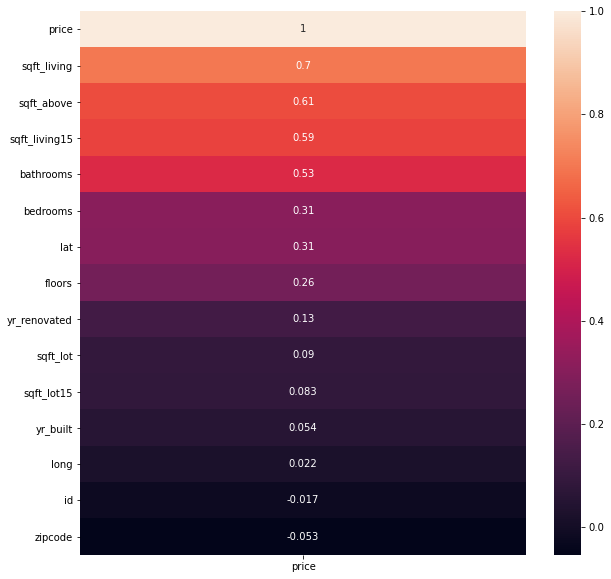

In [5]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr()[['price']].sort_values(by = ['price'], ascending = False), annot=True);

## Data Preparation

- Bedrooms: We filtered for houses with 5 or fewer bedrooms given that our business understanding is tailored to single family homes.
- Bathrooms: Along similar lines, we filtered for houses with 4 or fewer bathrooms. We also filtered out houses with less than 1 full bathroom given that there were a couple of outliers.
- Waterfront: Given the large number of values for "NO" in this column, we decided that dropping it would not significantly impact our analysis.
- View: We binned this into a binary Y/N column to create a more even distribution of values.
- Grade: We removed Luxury and Mansion grades keeping in mind our business understanding of single family homes. We also removed Low as only 14 houses meet criteria. 
- Year Renovated: Filled in null values.
- Square Footage of the Basement: We replaced the '?' values in some of the rows with "0", and then converted all values in this column to numeric (they were initially defined as "objects").
- Additional data preparation is done throughout the notebook as we built more models in order to improve performance. Notes pertaining to these additional preparations are included in the relevant sections below.

## Bedrooms

In [6]:
# dropping any larger then five, presumption being >5 not single family
df = df[df['bedrooms']<6]
df['bedrooms'].value_counts().sort_index()

1     196
2    2760
3    9824
4    6882
5    1601
Name: bedrooms, dtype: int64

## Bathrooms

In [7]:
# clearing out bathrooms over 4 and less than 1 - given distribution these are outliers 
df = df[(df['bathrooms']<=4) & (df['bathrooms']>=1)]
df['bathrooms'].value_counts().sort_index()

1.00    3844
1.25       9
1.50    1437
1.75    3031
2.00    1905
2.25    2029
2.50    5345
2.75    1148
3.00     699
3.25     575
3.50     708
3.75     139
4.00     117
Name: bathrooms, dtype: int64

## Waterfront

In [8]:
# SO few houses meet this criteria it is immaterial
df = df.drop(columns = 'waterfront')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20986 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20986 non-null  int64  
 1   date           20986 non-null  object 
 2   price          20986 non-null  float64
 3   bedrooms       20986 non-null  int64  
 4   bathrooms      20986 non-null  float64
 5   sqft_living    20986 non-null  int64  
 6   sqft_lot       20986 non-null  int64  
 7   floors         20986 non-null  float64
 8   view           20927 non-null  object 
 9   condition      20986 non-null  object 
 10  grade          20986 non-null  object 
 11  sqft_above     20986 non-null  int64  
 12  sqft_basement  20986 non-null  object 
 13  yr_built       20986 non-null  int64  
 14  yr_renovated   17247 non-null  float64
 15  zipcode        20986 non-null  int64  
 16  lat            20986 non-null  float64
 17  long           20986 non-null  float64
 18  sqft_l

## View

In [9]:
# Given distribution we decided this was worth keeping, but we decided to bin the results as 1 = view, 0 = no view
df['view_y_n'] = df['view'].map(lambda x: 0 if x =='NONE' else 1)
df = df.drop(columns = 'view')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20986 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20986 non-null  int64  
 1   date           20986 non-null  object 
 2   price          20986 non-null  float64
 3   bedrooms       20986 non-null  int64  
 4   bathrooms      20986 non-null  float64
 5   sqft_living    20986 non-null  int64  
 6   sqft_lot       20986 non-null  int64  
 7   floors         20986 non-null  float64
 8   condition      20986 non-null  object 
 9   grade          20986 non-null  object 
 10  sqft_above     20986 non-null  int64  
 11  sqft_basement  20986 non-null  object 
 12  yr_built       20986 non-null  int64  
 13  yr_renovated   17247 non-null  float64
 14  zipcode        20986 non-null  int64  
 15  lat            20986 non-null  float64
 16  long           20986 non-null  float64
 17  sqft_living15  20986 non-null  int64  
 18  sqft_l

## Grade

In [10]:
df = df[(df['grade'] != '13 Mansion') & (df['grade'] != '12 Luxury') & (df['grade'] != '4 Low')]
df['grade'].value_counts()

7 Average        8829
8 Good           5947
9 Better         2556
6 Low Average    2002
10 Very Good     1043
11 Excellent      310
5 Fair            224
Name: grade, dtype: int64

## Year Renovated

In [11]:
# Filling in missing values in this column
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20911 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20911 non-null  int64  
 1   date           20911 non-null  object 
 2   price          20911 non-null  float64
 3   bedrooms       20911 non-null  int64  
 4   bathrooms      20911 non-null  float64
 5   sqft_living    20911 non-null  int64  
 6   sqft_lot       20911 non-null  int64  
 7   floors         20911 non-null  float64
 8   condition      20911 non-null  object 
 9   grade          20911 non-null  object 
 10  sqft_above     20911 non-null  int64  
 11  sqft_basement  20911 non-null  object 
 12  yr_built       20911 non-null  int64  
 13  yr_renovated   20911 non-null  float64
 14  zipcode        20911 non-null  int64  
 15  lat            20911 non-null  float64
 16  long           20911 non-null  float64
 17  sqft_living15  20911 non-null  int64  
 18  sqft_l

## Square Footage of the Basement

In [12]:
# Cleaning up the weird '?' values in this column
df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x == '?' else x)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])
df['sqft_basement'].value_counts()

0.0       12982
600.0       208
500.0       206
700.0       202
800.0       192
          ...  
243.0         1
1930.0        1
283.0         1
588.0         1
2220.0        1
Name: sqft_basement, Length: 277, dtype: int64

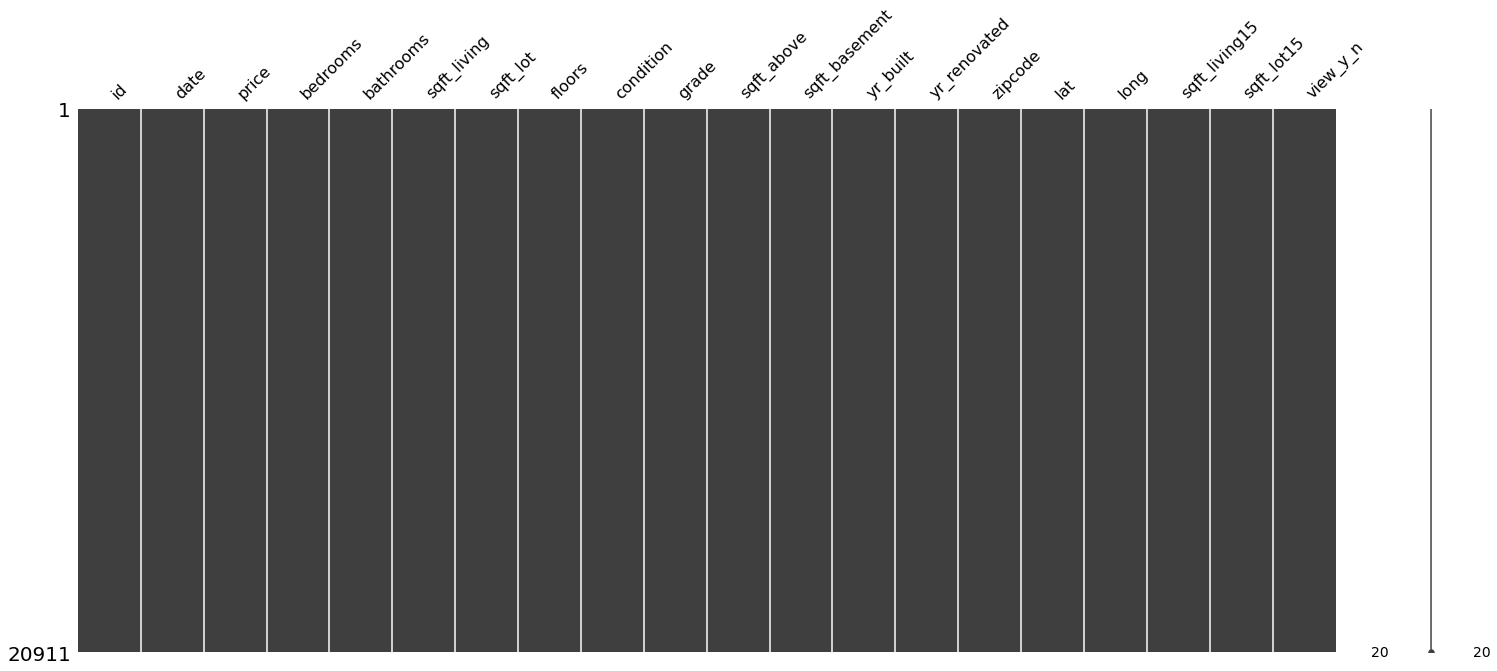

In [13]:
# Including this matrix to visually demonstrate that we have cleaned and dealt with missing values throughout
# the dataframe.
import missingno as msno
msno.matrix(df);

## ADD GIS DATA

Geodata was added to the notebook by processing shapefiles downloaded from [King County GIS Open Data](https://gis-kingcounty.opendata.arcgis.com/) Each file consisted of point data for sites of interest in King County: medical centers, schools, police stations, and farmers markets; each type of site was selected for its appeal to prospective homebuyers. Using a custom function the nearest station, market, etc. for each house in the primary dataframe was
discovered as well as its distance, in degrees, to the house. The file containing the function can be found [here](https://github.com/Shoemaker703/home_sales_analysis_project/blob/main/notebooks/Alex%20M/distance_function.py) and the workbook the processing was done in can be found [here](https://github.com/Shoemaker703/home_sales_analysis_project/blob/main/notebooks/Alex%20M/GIS_data.ipynb)

In [14]:
# This df includes all of the above cleaning PLUS the geodata from notebook cited above.
geo_df = pd.read_csv('data/kc_house_data_with_GIS_V2.csv', index_col = 0)

# Adding a Total Distance column for each house
geo_df['total_dist'] = geo_df['police_dist']+geo_df['medical_dist']+geo_df['school_dist']+geo_df['farmers_dist']

## Dropping columns

In [15]:
# Dropping Names of Police Stations, Schools, Hospitals, and Farmers Markets
geo_df = geo_df.drop(['geometry', 'police_name', 'school_name', 'medical_name', 'farmers_name'], axis = 1)
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20911 entries, 0 to 20910
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20911 non-null  int64  
 1   date           20911 non-null  object 
 2   price          20911 non-null  float64
 3   bedrooms       20911 non-null  int64  
 4   bathrooms      20911 non-null  float64
 5   sqft_living    20911 non-null  int64  
 6   sqft_lot       20911 non-null  int64  
 7   floors         20911 non-null  float64
 8   condition      20911 non-null  object 
 9   grade          20911 non-null  object 
 10  sqft_above     20911 non-null  int64  
 11  sqft_basement  20911 non-null  float64
 12  yr_built       20911 non-null  int64  
 13  yr_renovated   20911 non-null  float64
 14  zipcode        20911 non-null  int64  
 15  lat            20911 non-null  float64
 16  long           20911 non-null  float64
 17  sqft_living15  20911 non-null  int64  
 18  sqft_l

In [16]:
# Dropping other columns we know we won't use later.
geo_df = geo_df.drop(['date', 'zipcode', 'yr_built', 'yr_renovated', 'lat', 'long'], axis = 1)
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20911 entries, 0 to 20910
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20911 non-null  int64  
 1   price          20911 non-null  float64
 2   bedrooms       20911 non-null  int64  
 3   bathrooms      20911 non-null  float64
 4   sqft_living    20911 non-null  int64  
 5   sqft_lot       20911 non-null  int64  
 6   floors         20911 non-null  float64
 7   condition      20911 non-null  object 
 8   grade          20911 non-null  object 
 9   sqft_above     20911 non-null  int64  
 10  sqft_basement  20911 non-null  float64
 11  sqft_living15  20911 non-null  int64  
 12  sqft_lot15     20911 non-null  int64  
 13  view_y_n       20911 non-null  int64  
 14  police_dist    20911 non-null  float64
 15  school_dist    20911 non-null  float64
 16  medical_dist   20911 non-null  float64
 17  farmers_dist   20911 non-null  float64
 18  total_

## One Hot Encoding & Train/Test Split

In [17]:
# Setting up x to include all columns except for price
# Setting up y to be price as our dependent variable
X = geo_df.drop(columns = ['id', 'price'])
y = geo_df['price']

# One Hot Encoder will need this later so we're setting it up now
cat_cols= ['grade', 'condition']

In [18]:
# Setting up train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y,  test_size=0.3, random_state=42)

In [19]:
# Settning up OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore') 
X_train_ohe = ohe.fit_transform(X_train[cat_cols])

In [20]:
# Setting up a full data frame for visualizations we will use later in the notebook
X_train_ohe_data = pd.DataFrame(X_train_ohe, columns= ohe.get_feature_names(cat_cols), index = X_train.index)
X_train_full = pd.concat([X_train.drop(cat_cols, axis=1), X_train_ohe_data], axis = 1)
X_train_full

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view_y_n,...,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,condition_Average,condition_Fair,condition_Good,condition_Poor,condition_Very Good
3902,3,2.50,2090,9847,2.0,2090,0.0,2860,11483,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
18189,4,2.50,3250,235063,1.0,3250,0.0,1600,44287,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
13416,3,2.50,2588,5702,2.0,2588,0.0,2403,5703,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
13337,3,1.75,1710,4080,1.0,1130,580.0,1200,4080,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4154,4,1.75,1610,11305,1.0,1610,0.0,1870,11850,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,4,1.00,2180,10617,1.5,2180,0.0,1360,9519,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11964,3,2.25,2680,9162,1.0,1570,1110.0,2480,8261,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5390,2,1.00,820,4206,1.0,820,0.0,1810,7200,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
860,4,1.00,1820,5400,1.5,1820,0.0,1820,5400,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
# Doing the same code but for the X test set
X_test_ohe = ohe.transform(X_test[cat_cols])
X_test_ohe_data = pd.DataFrame(X_test_ohe, columns= ohe.get_feature_names(cat_cols), index = X_test.index)
X_test_full = pd.concat([X_test.drop(cat_cols, axis=1), X_test_ohe_data], axis = 1)
X_test_full

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view_y_n,...,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,condition_Average,condition_Fair,condition_Good,condition_Poor,condition_Very Good
4325,3,3.25,1370,1194,3.0,1370,0.0,1800,2678,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4680,2,1.00,1160,6911,1.0,1160,0.0,1120,6948,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5045,3,1.50,1520,7123,1.0,1520,0.0,1450,8023,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1713,2,1.00,840,12252,1.0,840,0.0,1010,11876,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7026,3,1.00,830,3386,1.0,830,0.0,1300,3844,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19939,2,2.00,1210,740,2.0,780,430.0,1480,1171,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12680,4,2.50,2130,6003,2.0,2130,0.0,1940,4529,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
575,2,2.50,1400,2958,2.0,1400,0.0,1540,2385,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
18192,3,2.25,1850,10855,1.0,1370,480.0,1850,8209,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
# Fixing column names to make our lives easier later.
X_train_full.columns = X_train_full.columns.str.replace(' ', '')
X_test_full.columns = X_test_full.columns.str.replace(' ', '')

In [23]:
# We will need to make visualizations of this data later, so we are going to combine X train and Y train
# after using the OHE.
X_y_train_full = pd.concat([X_train_full, y_train], axis = 1)

## Modeling (Simple Linear Regression)

- First we looked at the correlations between price and other features in the data set, and found that 'sqft_living' has the strongest correlation. Thus, we decided to use this feature for our simple model.
- We looked at additional information (especially GIS data) and ran other simple models, but found that 'sqft_living' still performed the best. We also cleaned some of the data in the section above based on insights we gained during the initial modeling process in order to improve the model performance.
    - Foe example, we initially tried filtering our y-axis (price) for houses that sold for less than $1,000,000, but found that this worsened our model's performance so we decided not to include this in our final version.
- The square footage of the living space in the house is an important feature for single family homes, as discussed above in the 'business understanding' section of this notebook (see references to Joe Gomez and Rocket Mortgage).

## Evaluation

We will evaluate each model as we go throughout the analysis process, and all comments regarding model performance will be included in the cell accompanying that model. In our multiple linear regression section, we will include a function to simplify our code. Evaluations throughout the notebook include calculations of VIF, MAE, MSE, RMSE, and R-squared data for the train and test sets.

### Baseline Understanding

- Given the importance of 'sqft_living' (as noted by its high correlation with price), we will keep that in each of our models throughout the notebook.
- This understanding is based on the correlation heatmap below, as well as our business understanding regarding the importance of the sqaure footage of a house to its sale price (see Joe Gomez and Rocket Mortgage references above).

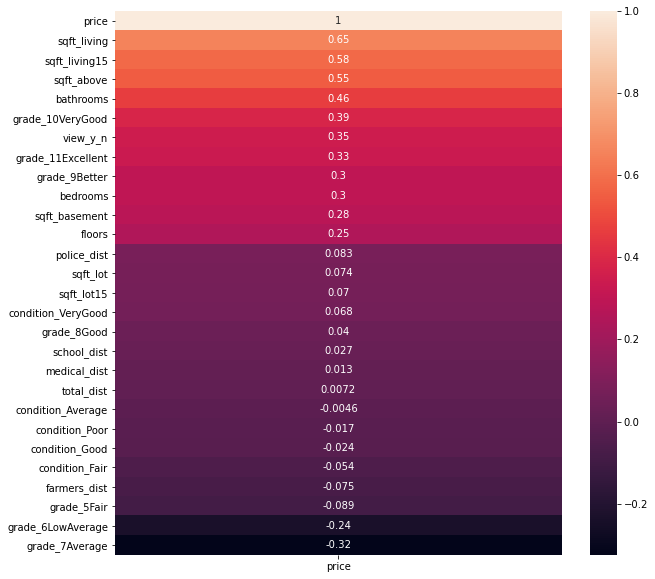

In [24]:
# Looking at correlations between price and other features.
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(X_y_train_full.corr()[['price']].sort_values(by = ['price'], ascending = False), annot=True);

### First Model

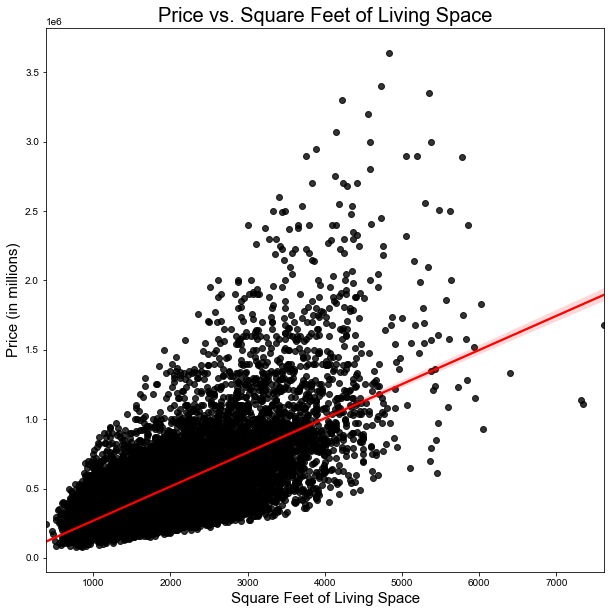

In [25]:
# sqft_living looks like the strongest positive correlation.

fig, ax = plt.subplots(figsize = (10,10))
ax = sns.regplot(x="sqft_living", y="price", data= X_y_train_full, scatter_kws={"color": "black"}, line_kws={"color": "red"})

plt.title('Price vs. Square Feet of Living Space', fontsize=20)
plt.xlabel('Square Feet of Living Space', fontsize=15)
plt.ylabel('Price (in millions)', fontsize=15)
sns.set_style("whitegrid")

plt.show;

In [26]:
# Performing an OLS model on sqft_living
model1 = sm.OLS(y_train, sm.add_constant(X_train_full['sqft_living'])).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                 1.094e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:53   Log-Likelihood:            -2.0166e+05
No. Observations:               14637   AIC:                         4.033e+05
Df Residuals:                   14635   BIC:                         4.033e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.241e+04   5136.657      4.362      0.000    1.23e+04    3.25e+04
sqft_living   246.0200      2.352    104.593      0.000     241.409     250.630
==============================================================================
Omnibus:                     7262.815   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83354.602
Skew:                           2.110   Prob(JB):                         0.00
Kurtosis:                      13.903   Cond. No.                     5.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Testing Assumptions for our 'Simple' Model

In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_full, y_train)
train_preds = lr.predict(X_train_full)
test_preds = lr.predict(X_test_full)

In [28]:
# Train is slightly underfit. Adding complexity should address this issue.
from sklearn.metrics import r2_score
print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
print(f"Test R2: {r2_score(y_test, test_preds):.4f}")

Train R2: 0.5946
Test R2: 0.6050


### Modeling Iterations

We will begin by using VIF to address issues related to multicollinearity:

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# defining an empty dataframe to capture the VIF scores
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train_full.values, i) for i in range(len(X_train_full.columns))]

# label the scores with their related columns
vif["features"] = X_train_full.columns

vif

# sqft_living has very, very high multicoliniarity - not necessarily an issue for the simple model since it's only the one
# variable, for the multiple model may be a concern

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,1.721083,bedrooms
1,2.760156,bathrooms
2,121.148351,sqft_living
3,2.246389,sqft_lot
4,2.021212,floors
5,103.630606,sqft_above
6,31.425542,sqft_basement
7,2.845185,sqft_living15
8,2.409949,sqft_lot15
9,1.158482,view_y_n


In [30]:
#improve multicoliniarity of suspected correlated features by dropping said features from df - sqft_above, sqft_basement

X_train_full.drop(['sqft_above', 'sqft_basement'], axis=1, inplace=True)
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14637 entries, 3902 to 15795
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            14637 non-null  int64  
 1   bathrooms           14637 non-null  float64
 2   sqft_living         14637 non-null  int64  
 3   sqft_lot            14637 non-null  int64  
 4   floors              14637 non-null  float64
 5   sqft_living15       14637 non-null  int64  
 6   sqft_lot15          14637 non-null  int64  
 7   view_y_n            14637 non-null  int64  
 8   police_dist         14637 non-null  float64
 9   school_dist         14637 non-null  float64
 10  medical_dist        14637 non-null  float64
 11  farmers_dist        14637 non-null  float64
 12  total_dist          14637 non-null  float64
 13  grade_10VeryGood    14637 non-null  float64
 14  grade_11Excellent   14637 non-null  float64
 15  grade_5Fair         14637 non-null  float64
 16  g

In [31]:
# Dropping same columns in test set.

X_test_full.drop(['sqft_above', 'sqft_basement'], axis=1, inplace=True)
X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6274 entries, 4325 to 1352
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            6274 non-null   int64  
 1   bathrooms           6274 non-null   float64
 2   sqft_living         6274 non-null   int64  
 3   sqft_lot            6274 non-null   int64  
 4   floors              6274 non-null   float64
 5   sqft_living15       6274 non-null   int64  
 6   sqft_lot15          6274 non-null   int64  
 7   view_y_n            6274 non-null   int64  
 8   police_dist         6274 non-null   float64
 9   school_dist         6274 non-null   float64
 10  medical_dist        6274 non-null   float64
 11  farmers_dist        6274 non-null   float64
 12  total_dist          6274 non-null   float64
 13  grade_10VeryGood    6274 non-null   float64
 14  grade_11Excellent   6274 non-null   float64
 15  grade_5Fair         6274 non-null   float64
 16  gra

In [32]:
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train_full.values, i) for i in range(len(X_train_full.columns))]

# label the scores with their related columns
vif["features"] = X_train_full.columns

vif

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,1.718149,bedrooms
1,2.703169,bathrooms
2,4.607791,sqft_living
3,2.242480,sqft_lot
4,1.595848,floors
5,2.744465,sqft_living15
6,2.409131,sqft_lot15
7,1.115371,view_y_n
8,inf,police_dist
9,inf,school_dist


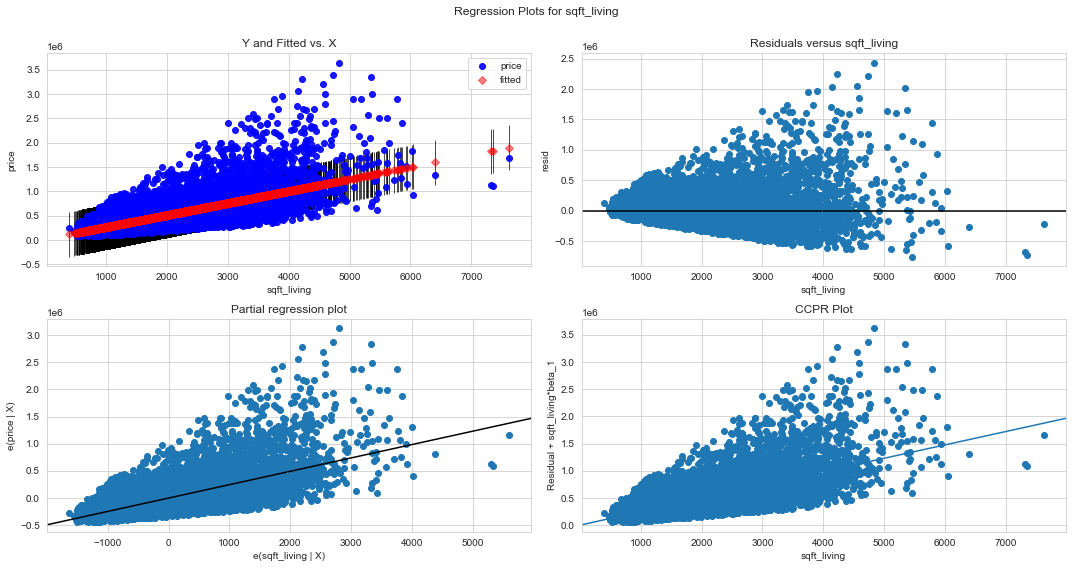

In [33]:
# Checking for variance and heteroskedacity. Saw similar issues with the scatter/regression plot above.
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model1, 'sqft_living', fig=fig)

<ipython-input-34-ae257fbed77b>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


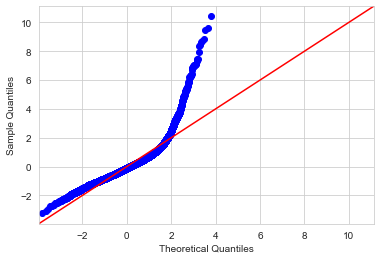

In [34]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
import scipy.stats as stats
residuals = model1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [35]:
# Trying to log transform the price variable to deal with skew.
y_log_train = np.log(y_train)
y_log_test = np.log(y_test)

In [36]:
# Performing an OLS model on sqft_living, now with log transformed price!
model1b = sm.OLS(y_log_train, sm.add_constant(X_train_full['sqft_living'])).fit()
model1b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                 1.144e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:55   Log-Likelihood:                -6416.8
No. Observations:               14637   AIC:                         1.284e+04
Df Residuals:                   14635   BIC:                         1.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2100      0.008   1476.106      0.000      12.194      12.226
sqft_living     0.0004   3.79e-06    106.940      0.000       0.000       0.000
==============================================================================
Omnibus:                       39.543   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.337
Skew:                           0.067   Prob(JB):                     3.50e-08
Kurtosis:                       2.804   Cond. No.                     5.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-37-27bdd74489f2>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


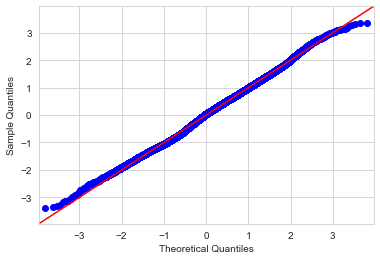

In [37]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
residuals = model1b.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

## Modeling (Multiple Linear Regression)

- After evaluating our simple model's performance, we decided to start adding features in addition to 'sqft_living' to see if we could improve our model's performance. 
- We designed a function (see below) to simplify the model evaluation process for our code.
    - Function takes in x_train, x_test, y_train, and test variables along with column names in order to show VIF, MAE, MSE, RMSE, and QQ plot for each model.
- For the most part, we found that adding features to our model improved its performance. However, we initially used only the top  condition values but decided to bin this value with the category below to make our results more easily translatable to our stakeholders. Model performance decline with this binning was minimal (~.002), so we decided to keep these changes for our final model. We eventually decided to repeat this binning process with the grade variable which improved our model performance significantly—this model with both binned grade and condition variables was kept as the final version, and we deleted our model with just the binned condition variable. If given more time, we will explore more options pertaining to specific combinations with these categories.

In [38]:
def test_formula(model, col_names, x_tr, x_te, y_tr, y_te):
    """
    Function takes in x_train, x_test, y_train, and test variables
    along with column names in order to show VIF, MAE, MSE, RMSE, 
    and QQ plot for each model.
    
    Inputs: 
        model = OLS model
        col_names = columns for x axis testing
        x_tr = df with x_train data
        x_te = df with x_test data
        y_tr = df with y_train data
        y_te = df with y_test data
    
    Returns:
        Nothing
    """    
    # QQ Plot
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
    fig.show()
    
    # VIF
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(x_tr.values, i) for i in range(len(col_names))]
    vif["features"] = col_names
    print(vif)
    print('**********************************')
    # MAE, MSE, RMSE
    train_preds = model.predict(sm.add_constant(x_tr[col_names]))
    test_preds = model.predict(sm.add_constant(x_te[col_names]))
    print("Metrics:")
    # R2
    print(f"R2 Train: {r2_score(y_tr, train_preds):.3f}")
    print(f"R2 Test: {r2_score(y_te, test_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error Train: {mean_absolute_error(y_tr, train_preds):.3f}")
    print(f"Mean Absolute Error Test: {mean_absolute_error(y_te, test_preds):.3f}")
    # MSE
    print(f"Mean Squared Error Train: {mean_squared_error(y_tr, train_preds):.3f}")
    print(f"Mean Squared Error Test: {mean_squared_error(y_te, test_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error Train: {mean_squared_error(y_tr, train_preds, squared=False):.3f}")
    print(f"Root Mean Squared Error Test: {mean_squared_error(y_te, test_preds, squared=False):.3f}")
    print('**********************************')

In [39]:
# Performing an OLS model on sqft_living and view_y_n.
model2 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     6298.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:55   Log-Likelihood:                -6098.1
No. Observations:               14637   AIC:                         1.220e+04
Df Residuals:                   14634   BIC:                         1.222e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2314      0.008   1503.125      0.000      12.215      12.247
sqft_living     0.0004   3.82e-06     99.995      0.000       0.000       0.000
view_y_n        0.2722      0.011     25.521      0.000       0.251       0.293
==============================================================================
Omnibus:                       41.147   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.317
Skew:                           0.000   Prob(JB):                     9.61e-08
Kurtosis:                       2.770   Cond. No.                     7.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

        VIF     features
0  1.718149  sqft_living
1  2.703169     view_y_n
**********************************
Metrics:
R2 Train: 0.463
R2 Test: 0.474
Mean Absolute Error Train: 0.299
Mean Absolute Error Test: 0.301
Mean Squared Error Train: 0.135
Mean Squared Error Test: 0.136
Root Mean Squared Error Train: 0.367
Root Mean Squared Error Test: 0.368
**********************************


<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


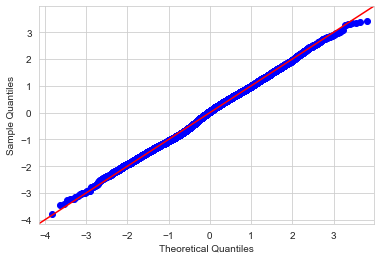

In [40]:
cols2 = ['sqft_living', 'view_y_n']
test_formula(model2, cols2, X_train_full, X_test_full, y_log_train, y_log_test)

After adding 'view_y_n' the r-squared score for our model improved from 0.357 to 0.373.

In [41]:
# Performing an OLS model on sqft_living, view_y_n, and bedrooms.
# This model improves r-sqaured from 0.463 to 0.467
model3 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'bedrooms']])).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     4279.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:56   Log-Likelihood:                -6033.1
No. Observations:               14637   AIC:                         1.207e+04
Df Residuals:                   14633   BIC:                         1.210e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.3425      0.013    974.956      0.000      12.318      12.367
sqft_living     0.0004   4.73e-06     87.490      0.000       0.000       0.000
view_y_n        0.2595      0.011     24.303      0.000       0.239       0.280
bedrooms       -0.0527      0.005    -11.421      0.000      -0.062      -0.044
==============================================================================
Omnibus:                       22.265   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.715
Skew:                          -0.005   Prob(JB):                     8.63e-05
Kurtosis:                       2.825   Cond. No.                     9.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF     features
0  1.718149  sqft_living
1  2.703169     view_y_n
2  4.607791     bedrooms
**********************************
Metrics:
R2 Train: 0.467
R2 Test: 0.479
Mean Absolute Error Train: 0.297
Mean Absolute Error Test: 0.299
Mean Squared Error Train: 0.134
Mean Squared Error Test: 0.134
Root Mean Squared Error Train: 0.365
Root Mean Squared Error Test: 0.367
**********************************


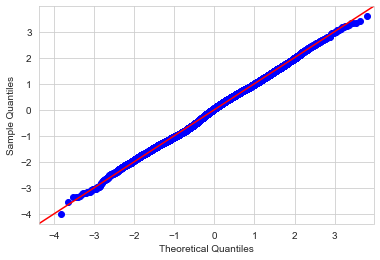

In [42]:
cols3 = ['sqft_living', 'view_y_n', 'bedrooms']
test_formula(model3, cols3, X_train_full, X_test_full, y_log_train, y_log_test)

In [43]:
# Performing an OLS model on sqft_living, view_y_n, bedrooms, and bathrooms.
# This model improves r-sqaured from 0.467 to 0.471
model4 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'bedrooms', 'bathrooms']])).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     3251.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:56   Log-Likelihood:                -5988.3
No. Observations:               14637   AIC:                         1.199e+04
Df Residuals:                   14632   BIC:                         1.202e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.3056      0.013    931.643      0.000      12.280      12.331
sqft_living     0.0004   5.88e-06     64.703      0.000       0.000       0.000
view_y_n        0.2630      0.011     24.687      0.000       0.242       0.284
bedrooms       -0.0584      0.005    -12.583      0.000      -0.067      -0.049
bathrooms       0.0593      0.006      9.488      0.000       0.047       0.071
==============================================================================
Omnibus:                       23.900   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.334
Skew:                           0.026   Prob(JB):                     3.84e-05
Kurtosis:                       2.825   Cond. No.                     9.97e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF     features
0  1.718149  sqft_living
1  2.703169     view_y_n
2  4.607791     bedrooms
3  2.242480    bathrooms
**********************************
Metrics:
R2 Train: 0.471
R2 Test: 0.483
Mean Absolute Error Train: 0.296
Mean Absolute Error Test: 0.297
Mean Squared Error Train: 0.133
Mean Squared Error Test: 0.134
Root Mean Squared Error Train: 0.364
Root Mean Squared Error Test: 0.365
**********************************


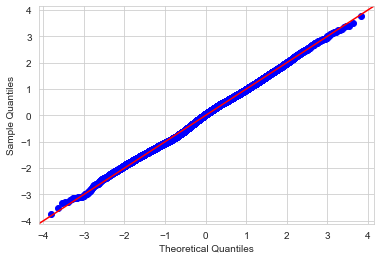

In [44]:
cols4 = ['sqft_living', 'view_y_n', 'bedrooms', 'bathrooms']
test_formula(model4, cols4, X_train_full, X_test_full, y_log_train, y_log_test)

In [45]:
# Performing an OLS model on sqft_living, view_y_n, and total_dist.
# This model improves r-sqaured from 0.471 to 0.473
model5 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist']])).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     4377.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:56   Log-Likelihood:                -5955.7
No. Observations:               14637   AIC:                         1.192e+04
Df Residuals:                   14633   BIC:                         1.195e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2884      0.009   1407.234      0.000      12.271      12.306
sqft_living     0.0004   3.85e-06    102.359      0.000       0.000       0.000
view_y_n        0.2683      0.011     25.395      0.000       0.248       0.289
total_dist     -0.7795      0.046    -16.954      0.000      -0.870      -0.689
==============================================================================
Omnibus:                       47.115   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.671
Skew:                          -0.066   Prob(JB):                     2.43e-09
Kurtosis:                       2.781   Cond. No.                     3.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF     features
0  1.718149  sqft_living
1  2.703169     view_y_n
2  4.607791   total_dist
**********************************
Metrics:
R2 Train: 0.473
R2 Test: 0.485
Mean Absolute Error Train: 0.296
Mean Absolute Error Test: 0.297
Mean Squared Error Train: 0.132
Mean Squared Error Test: 0.133
Root Mean Squared Error Train: 0.363
Root Mean Squared Error Test: 0.365
**********************************


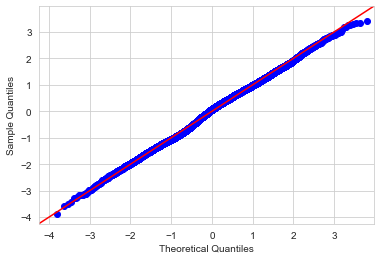

In [46]:
cols5 = ['sqft_living', 'view_y_n', 'total_dist']
test_formula(model5, cols5, X_train_full, X_test_full, y_log_train, y_log_test)

In [47]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, and bedrooms.
# This model improves r-sqaured from 0.473 to 0.479
model6 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'bedrooms']])).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     3361.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:57   Log-Likelihood:                -5873.4
No. Observations:               14637   AIC:                         1.176e+04
Df Residuals:                   14632   BIC:                         1.179e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.4158      0.013    942.704      0.000      12.390      12.442
sqft_living     0.0004   4.77e-06     90.253      0.000       0.000       0.000
view_y_n        0.2539      0.011     24.027      0.000       0.233       0.275
total_dist     -0.8239      0.046    -17.969      0.000      -0.914      -0.734
bedrooms       -0.0589      0.005    -12.866      0.000      -0.068      -0.050
==============================================================================
Omnibus:                       30.859   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.584
Skew:                          -0.076   Prob(JB):                     6.21e-07
Kurtosis:                       2.846   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF     features
0  1.718149  sqft_living
1  2.703169     view_y_n
2  4.607791   total_dist
3  2.242480     bedrooms
**********************************
Metrics:
R2 Train: 0.479
R2 Test: 0.491
Mean Absolute Error Train: 0.294
Mean Absolute Error Test: 0.295
Mean Squared Error Train: 0.131
Mean Squared Error Test: 0.131
Root Mean Squared Error Train: 0.361
Root Mean Squared Error Test: 0.363
**********************************


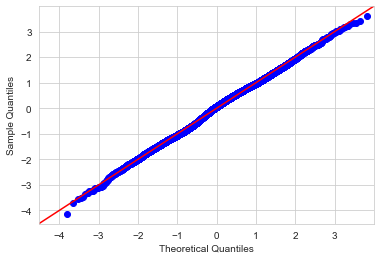

In [48]:
cols6 = ['sqft_living', 'view_y_n', 'total_dist', 'bedrooms']
test_formula(model6, cols6, X_train_full, X_test_full, y_log_train, y_log_test)

In [49]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, bedrooms, and bathrooms.
# This model improves r-sqaured from 0.479 to 0.482
model7 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'bedrooms', 'bathrooms']])).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     2725.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:57   Log-Likelihood:                -5826.1
No. Observations:               14637   AIC:                         1.166e+04
Df Residuals:                   14631   BIC:                         1.171e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.3787      0.014    905.352      0.000      12.352      12.405
sqft_living     0.0004   5.89e-06     67.415      0.000       0.000       0.000
view_y_n        0.2574      0.011     24.421      0.000       0.237       0.278
total_dist     -0.8275      0.046    -18.103      0.000      -0.917      -0.738
bedrooms       -0.0647      0.005    -14.056      0.000      -0.074      -0.056
bathrooms       0.0601      0.006      9.738      0.000       0.048       0.072
==============================================================================
Omnibus:                       22.776   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.203
Skew:                          -0.044   Prob(JB):                     4.10e-05
Kurtosis:                       2.841   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF     features
0  1.718149  sqft_living
1  2.703169     view_y_n
2  4.607791   total_dist
3  2.242480     bedrooms
4  1.595848    bathrooms
**********************************
Metrics:
R2 Train: 0.482
R2 Test: 0.494
Mean Absolute Error Train: 0.293
Mean Absolute Error Test: 0.294
Mean Squared Error Train: 0.130
Mean Squared Error Test: 0.131
Root Mean Squared Error Train: 0.360
Root Mean Squared Error Test: 0.361
**********************************


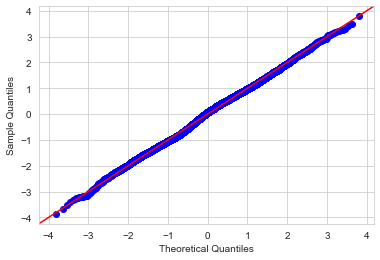

In [50]:
cols7 = ['sqft_living', 'view_y_n', 'total_dist', 'bedrooms', 'bathrooms']
test_formula(model7, cols7, X_train_full, X_test_full, y_log_train, y_log_test)

In [51]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, and sqft_living15.
# This model improves r-sqaured from 0.482 to 0.495
model8 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15']])).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     3581.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:57   Log-Likelihood:                -5646.7
No. Observations:               14637   AIC:                         1.130e+04
Df Residuals:                   14632   BIC:                         1.134e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.1665      0.010   1237.461      0.000      12.147      12.186
sqft_living       0.0003   5.51e-06     53.198      0.000       0.000       0.000
view_y_n          0.2374      0.010     22.786      0.000       0.217       0.258
total_dist       -0.9264      0.045    -20.407      0.000      -1.015      -0.837
sqft_living15     0.0002   6.99e-06     25.120      0.000       0.000       0.000
==============================================================================
Omnibus:                       78.606   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.990
Skew:                          -0.062   Prob(JB):                     9.40e-14
Kurtosis:                       2.712   Cond. No.                     4.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF       features
0  1.718149    sqft_living
1  2.703169       view_y_n
2  4.607791     total_dist
3  2.242480  sqft_living15
**********************************
Metrics:
R2 Train: 0.495
R2 Test: 0.501
Mean Absolute Error Train: 0.290
Mean Absolute Error Test: 0.293
Mean Squared Error Train: 0.127
Mean Squared Error Test: 0.129
Root Mean Squared Error Train: 0.356
Root Mean Squared Error Test: 0.359
**********************************


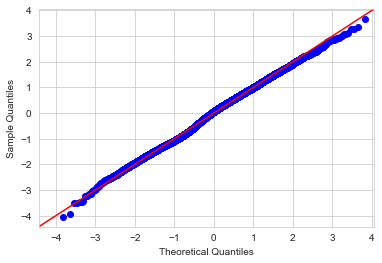

In [52]:
cols8 = ['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15']
test_formula(model8, cols8, X_train_full, X_test_full, y_log_train, y_log_test)

In [53]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, sqft_living15, sqft_living15, and bedrooms.
# This model improves r-sqaured from 0.495 to 0.500
model9 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms']])).fit()
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     2924.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:58   Log-Likelihood:                -5572.1
No. Observations:               14637   AIC:                         1.116e+04
Df Residuals:                   14631   BIC:                         1.120e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.2875      0.014    883.833      0.000      12.260      12.315
sqft_living       0.0003   6.22e-06     52.916      0.000       0.000       0.000
view_y_n          0.2245      0.010     21.542      0.000       0.204       0.245
total_dist       -0.9653      0.045    -21.319      0.000      -1.054      -0.877
sqft_living15     0.0002   6.96e-06     24.797      0.000       0.000       0.000
bedrooms         -0.0549      0.004    -12.244      0.000      -0.064      -0.046
==============================================================================
Omnibus:                       54.204   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.251
Skew:                          -0.072   Prob(JB):                     1.49e-10
Kurtosis:                       2.769   Cond. No.                     4.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF       features
0  1.718149    sqft_living
1  2.703169       view_y_n
2  4.607791     total_dist
3  2.242480  sqft_living15
4  1.595848       bedrooms
**********************************
Metrics:
R2 Train: 0.500
R2 Test: 0.506
Mean Absolute Error Train: 0.289
Mean Absolute Error Test: 0.291
Mean Squared Error Train: 0.125
Mean Squared Error Test: 0.128
Root Mean Squared Error Train: 0.354
Root Mean Squared Error Test: 0.357
**********************************


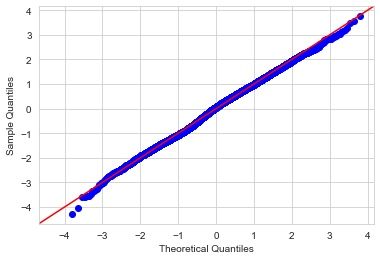

In [54]:
cols9 = ['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms']
test_formula(model9, cols9, X_train_full, X_test_full, y_log_train, y_log_test)

In [55]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, sqft_living15, sqft_living15, bedrooms, and bathrooms.
# This model improves r-sqaured from 0.500 to 0.503
model10 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'bathrooms']])).fit()
model10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     2465.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:58   Log-Likelihood:                -5529.5
No. Observations:               14637   AIC:                         1.107e+04
Df Residuals:                   14630   BIC:                         1.113e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.2542      0.014    855.603      0.000      12.226      12.282
sqft_living       0.0003   7.02e-06     42.559      0.000       0.000       0.000
view_y_n          0.2280      0.010     21.931      0.000       0.208       0.248
total_dist       -0.9672      0.045    -21.421      0.000      -1.056      -0.879
sqft_living15     0.0002   6.94e-06     24.599      0.000       0.000       0.000
bedrooms         -0.0604      0.005    -13.377      0.000      -0.069      -0.052
bathrooms         0.0560      0.006      9.244      0.000       0.044       0.068
==============================================================================
Omnibus:                       51.869   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.648
Skew:                          -0.051   Prob(JB):                     9.04e-10
Kurtosis:                       2.759   Cond. No.                     4.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF       features
0  1.718149    sqft_living
1  2.703169       view_y_n
2  4.607791     total_dist
3  2.242480  sqft_living15
4  1.595848       bedrooms
5  2.744465      bathrooms
**********************************
Metrics:
R2 Train: 0.503
R2 Test: 0.509
Mean Absolute Error Train: 0.288
Mean Absolute Error Test: 0.290
Mean Squared Error Train: 0.125
Mean Squared Error Test: 0.127
Root Mean Squared Error Train: 0.353
Root Mean Squared Error Test: 0.356
**********************************


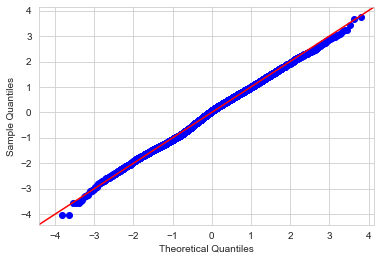

In [56]:
cols10 = ['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'bathrooms']
test_formula(model10, cols10, X_train_full, X_test_full, y_log_train, y_log_test)

In [57]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, sqft_living15, sqft_living15, bedrooms, condition_VeryGood.
# This model improves r-sqaured from 0.503 to 0.505
model11 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'condition_VeryGood']])).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     2490.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:58   Log-Likelihood:                -5493.4
No. Observations:               14637   AIC:                         1.100e+04
Df Residuals:                   14630   BIC:                         1.105e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.2717      0.014    883.784      0.000      12.244      12.299
sqft_living            0.0003   6.18e-06     52.876      0.000       0.000       0.000
view_y_n               0.2180      0.010     21.007      0.000       0.198       0.238
total_dist            -0.9397      0.045    -20.842      0.000      -1.028      -0.851
sqft_living15          0.0002   6.94e-06     25.814      0.000       0.000       0.000
bedrooms              -0.0568      0.004    -12.725      0.000      -0.066      -0.048
condition_VeryGood     0.1361      0.011     12.582      0.000       0.115       0.157
==============================================================================
Omnibus:                       48.676   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.344
Skew:                          -0.071   Prob(JB):                     1.05e-09
Kurtosis:                       2.782   Cond. No.                     4.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF            features
0  1.718149         sqft_living
1  2.703169            view_y_n
2  4.607791          total_dist
3  2.242480       sqft_living15
4  1.595848            bedrooms
5  2.744465  condition_VeryGood
**********************************
Metrics:
R2 Train: 0.505
R2 Test: 0.514
Mean Absolute Error Train: 0.287
Mean Absolute Error Test: 0.289
Mean Squared Error Train: 0.124
Mean Squared Error Test: 0.126
Root Mean Squared Error Train: 0.352
Root Mean Squared Error Test: 0.354
**********************************


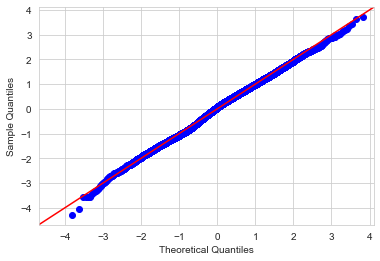

In [58]:
cols11 = ['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'condition_VeryGood']
test_formula(model11, cols11, X_train_full, X_test_full, y_log_train, y_log_test)

In [59]:
# Seeing the impact of condition, we wanted to bin the condition columns to see how a house in good condition
# has an impact on our model.
X_train_full['pos_condition'] = X_train_full['condition_Good'] + X_train_full['condition_VeryGood']
X_test_full['pos_condition'] = X_test_full['condition_Good'] + X_test_full['condition_VeryGood']

# In our correlation heatmap above we also saw high grades had a strong impact on sale price, 
# so we will bin these columns in a similar fashion.
X_train_full['pos_grade'] = X_train_full['grade_9Better'] + X_train_full['grade_10VeryGood'] + X_train_full['grade_11Excellent']
X_test_full['pos_grade'] = X_test_full['grade_9Better'] + X_test_full['grade_10VeryGood'] + X_test_full['grade_11Excellent']

### Here is what these columns mean according to the King County Assessor website (https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) :

**Condition:**\
4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5 = Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

**Grade:**\
9 = Better architectural design with extra interior and exterior design and quality.

10 = Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 = Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

### Final Model

In [60]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, sqft_living15, sqft_living15, bedrooms, condition_VeryGood.
# This model improves r-sqaured from 0.505 to 0.523
model12 = sm.OLS(y_log_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'pos_condition', 'pos_grade']])).fit()
model12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     2288.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:59   Log-Likelihood:                -5230.6
No. Observations:               14637   AIC:                         1.048e+04
Df Residuals:                   14629   BIC:                         1.054e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.3494      0.014    866.888      0.000      12.321      12.377
sqft_living       0.0003   6.46e-06     43.189      0.000       0.000       0.000
view_y_n          0.2151      0.010     21.070      0.000       0.195       0.235
total_dist       -0.9476      0.044    -21.416      0.000      -1.034      -0.861
sqft_living15     0.0001   7.02e-06     19.286      0.000       0.000       0.000
bedrooms         -0.0428      0.004     -9.643      0.000      -0.052      -0.034
pos_condition     0.0781      0.006     12.751      0.000       0.066       0.090
pos_grade         0.2377      0.010     24.293      0.000       0.219       0.257
==============================================================================
Omnibus:                       61.221   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.517
Skew:                          -0.105   Prob(JB):                     1.45e-12
Kurtosis:                       2.787   Cond. No.                     4.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


        VIF       features
0  1.718149    sqft_living
1  2.703169       view_y_n
2  4.607791     total_dist
3  2.242480  sqft_living15
4  1.595848       bedrooms
5  2.744465  pos_condition
6  2.409131      pos_grade
**********************************
Metrics:
R2 Train: 0.523
R2 Test: 0.527
Mean Absolute Error Train: 0.281
Mean Absolute Error Test: 0.285
Mean Squared Error Train: 0.120
Mean Squared Error Test: 0.122
Root Mean Squared Error Train: 0.346
Root Mean Squared Error Test: 0.350
**********************************


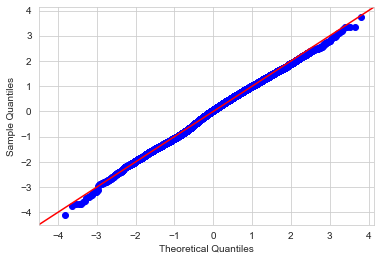

In [61]:
cols12 = ['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'pos_condition', 'pos_grade']
test_formula(model12, cols12, X_train_full, X_test_full, y_log_train, y_log_test)

In [62]:
# Now that we have our final model, we want to scale our data to be able to discuss coefficients in relation 
# to one another.
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

final_cols = X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'pos_condition', 'pos_grade']]
final_cols_test = X_test_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'pos_condition', 'pos_grade']]

X_train_features_final = final_cols.apply(normalize)
X_test_features_final = final_cols_test.apply(normalize)

In [63]:
model12b = sm.OLS(y_log_train, sm.add_constant(X_train_features_final)).fit()
model12b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     2288.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:00:59   Log-Likelihood:                -5230.6
No. Observations:               14637   AIC:                         1.048e+04
Df Residuals:                   14629   BIC:                         1.054e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.0301      0.003   4556.102      0.000      13.024      13.036
sqft_living       0.2284      0.005     43.189      0.000       0.218       0.239
view_y_n          0.0630      0.003     21.070      0.000       0.057       0.069
total_dist       -0.0631      0.003    -21.416      0.000      -0.069      -0.057
sqft_living15     0.0883      0.005     19.286      0.000       0.079       0.097
bedrooms         -0.0350      0.004     -9.643      0.000      -0.042      -0.028
pos_condition     0.0370      0.003     12.751      0.000       0.031       0.043
pos_grade         0.0925      0.004     24.293      0.000       0.085       0.100
==============================================================================
Omnibus:                       61.221   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.517
Skew:                          -0.105   Prob(JB):                     1.45e-12
Kurtosis:                       2.787   Cond. No.                         3.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

        VIF       features
0  3.419479    sqft_living
1  1.093891       view_y_n
2  1.059841     total_dist
3  2.565343  sqft_living15
4  1.607683       bedrooms
5  1.030867  pos_condition
6  1.773764      pos_grade
**********************************
Metrics:
R2 Train: 0.523
R2 Test: 0.527
Mean Absolute Error Train: 0.281
Mean Absolute Error Test: 0.285
Mean Squared Error Train: 0.120
Mean Squared Error Test: 0.122
Root Mean Squared Error Train: 0.346
Root Mean Squared Error Test: 0.350
**********************************


<ipython-input-38-0dbe20d79a57>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


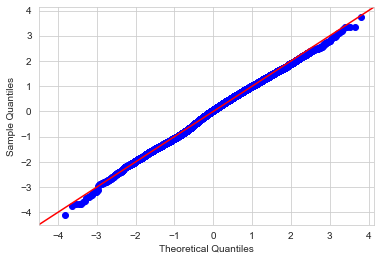

In [64]:
final_col_names = ['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'pos_condition', 'pos_grade']
test_formula(model12b, final_col_names, X_train_features_final, X_test_features_final, y_log_train, y_log_test)

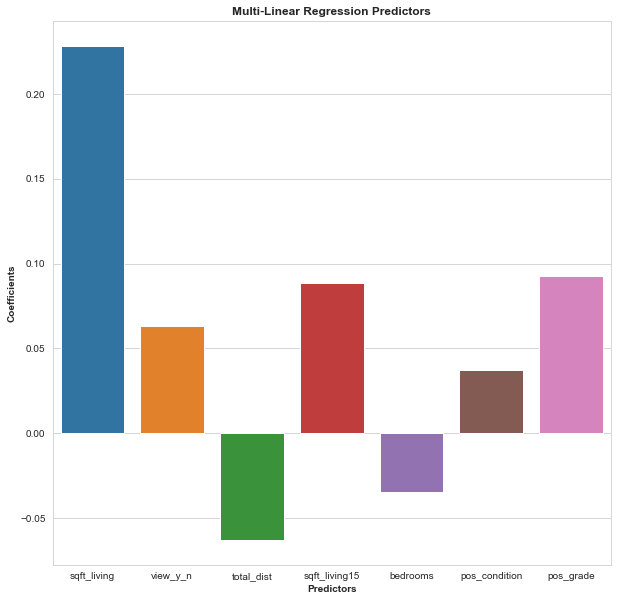

In [65]:
# plotting our parameter coefficients
fig, ax = plt.subplots(figsize = (10,10))

x = model12b.params[1:].index
y = model12b.params[1:].values

sns.barplot(x = x, y = y)
sns.set_style(style = "darkgrid")
plt.title("Multi-Linear Regression Predictors", fontweight='bold')
plt.ylabel("Coefficients", fontweight='bold')
plt.xlabel("Predictors", fontweight='bold');


## Conclusions


Our final model explains roughly 52% of the variance in sale price for homes in King County, WA.
- The square footage of the living area in each house accounts for a 22.8% increase in sale price.
- The sqaure footage of the living area in each of the neighboring 15 houses accounts for an 8.8% increase in sale price.
    - We think it makes sense that there is a connection between the square footage of houses in the same neighborhood. As both of these features increase in size, the sale price increases. In other words, large houses surrounded by other large houses will probably be more appealing to buyers rather than large houses in neighborhoods full of smaller houses.
- We also found that a house with a high grade ("Better, Very Good, or Excellent") accounts for a 9.3% increase in sale price. Similarly, we found that houses with an above average condition account for a 3.7% increase in sale price. 
    - Our model saw a slightly better performance when we only used houses with a "Very Good" condition, but we felt that using "Above Average" (includes "Very Good" and "Good" conditions) would be somewhat easier to explain to our non-technical stakeholders.
- If the house has a good view, our model accounts for a 6.3% increase in sale price.
    - This is interesting in that our model suggests that there is a 6.3% decrease in sale price for houses that are closer to places of interest in the neighborhood (e.g. police stations, hospitals, farmers markets, schools, etc.). The negative correlation is to be expected given that the closer you are to some of these places of interest, the lower the total distance value is in our calculations, which corresponds to an increase in sale price.
- We were initially surprised to see a 3.5% decrease in sale price correlated with an increase in number of bedrooms, but our thought is that once a house has more than three bedrooms (the mean for this data set is 3.3, which we can round down to 3) it might become less appealing to buyers.

## Limitations

- Given that we focused on what we considered "single family homes," there are some more expensive/fancy houses that our model will not be able to predict very effectively.
- Our distance metric weighted all four points of interest equally. In future iterations, we will explore giving different values to different places of interest based on type to see how this impacts model performance.

## Future Directions

There are a number of possible directions to go in the future, but here are some thoughts we have regarding possible ways to expand this initial study:
- Look into more detailed location information to see the impacts of different places of interest on sale price.
- Look into more specific impacts of individual conditions and grades (rather than the binned versions of those features we used in our final model).
- More feature engineering with bedrooms and bathrooms (what combination of these features is most strongly correlated with sale price).
- Organizing data by zipcode to see what impact this has on our model.
- Analyzing year built/renovated.
- Examine properties with multiple sale records to see what trends led to changes in sale price.